In [551]:
import sys, os.path as p; sys.path.insert(0, p.abspath('../'))

from tools.charting.plot_helpers import *
from tools.analysis.timeseries import *
from tools.analysis.data import make_forward_returns_matrix, permutate_params
from tools.analysis.tools import scols, srows, drop_duplicated_indexes
from tools.utils.utils import mstruct

from tools.loaders.binance import load_binance_data
from tqdm.notebook import tqdm
from models.research_utils import rough_simulation
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
setup_mpl_theme('light') # run this if need to switch to light charts theme

In [2]:
import ira
%alphalab dark

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx
(c) 2017, AppliedAlpha Infrastructure for Quantitative Research and Analysis, ver. master: 0.1414


In [ ]:
instrument = 'BTCUSDT'
data_1m = load_binance_data(instrument, '1m', path='../data')

# First look

Here we will find out statistics of breakouts for support and resistance levels derived from pivots points indicator (see https://www.investopedia.com/terms/p/pivotpoint.asp).

We will find what's best period for detecting levels using 3 different timeframes for pivots (Daily, Weekly and Monthly) and different methods for building support resist levels.

Here examples of daily and weekly pivots with 1H prices:

In [552]:
pp_d = pivot_point(data_1m, timeframe='D', timezone='UTC')
pp_w = pivot_point(data_1m, timeframe='W', timezone='UTC')
pp_m = pivot_point(data_1m, timeframe='M', timezone='UTC')
g1 = LookingGlass([ohlc_resample(data_1m, '1H'), pp_d], {})
g2 = LookingGlass([ohlc_resample(data_1m, '1H'), pp_w], {})
g3 = LookingGlass([ohlc_resample(data_1m, '1H'), pp_m], {})

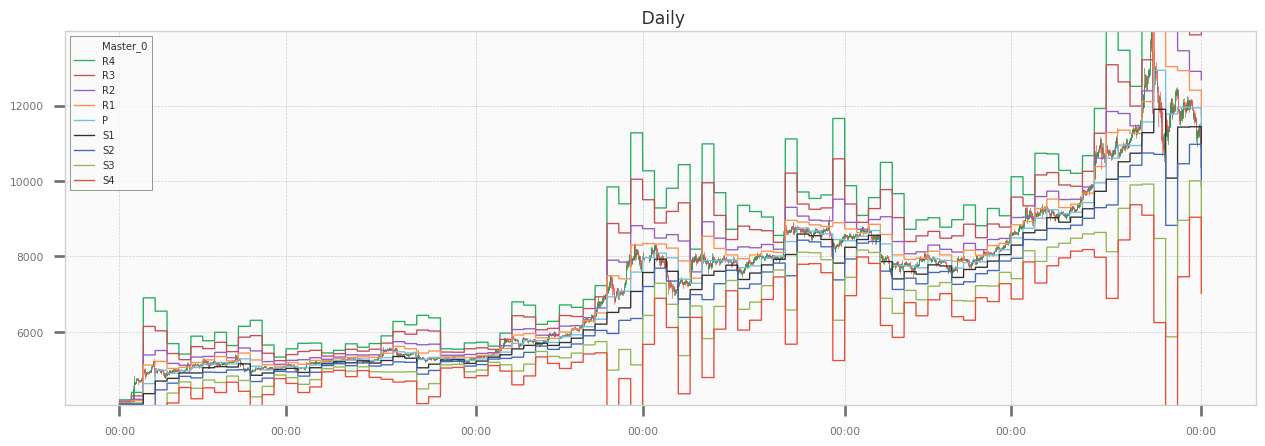

In [553]:
fig(16, 5)
g1.look('2019-04-01', '2019-07-01', title='Daily')

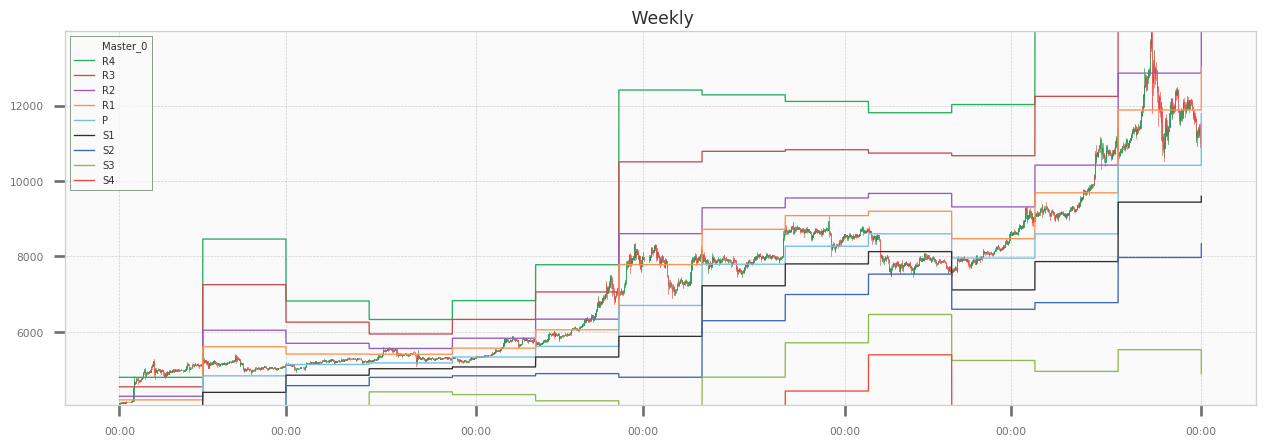

In [554]:
fig(16, 5)
g2.look('2019-04-01', '2019-07-01', title='Weekly')

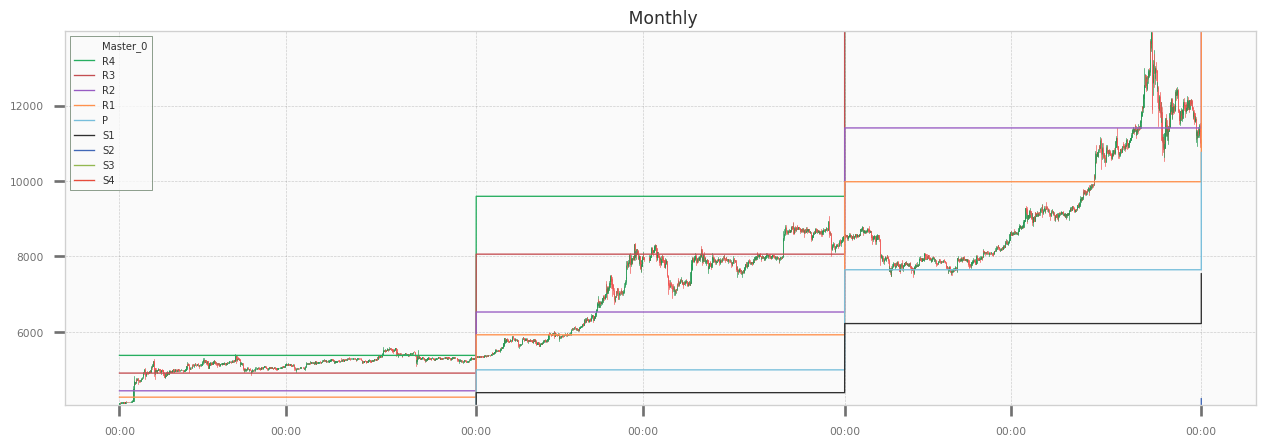

In [555]:
fig(16, 5)
g3.look('2019-04-01', '2019-07-01', title='Monthly')

We could expect more signals from daily pivots levels (including wrong). On the other hand using monthly levels may lead to to tiny numbers of breakouts (seems monthly levels are good to be used as support/resistance in sense of reverting trading). So we could expect that using weekly may be a tradeoff gere.

# Breakout statistics

Here we define method for finding points where price breaks support and resistance levels.


In [558]:
tolist = lambda x: [x] if not isinstance(x, (list, tuple)) else x

def find_pp_breakouts(data, timeframe, res_level, sup_level, pp_frame='D', timezone='UTC', method='classic'):
    """
    Find out breakouts (point of interests) of pivot points levels
    """
    data = ohlc_resample(data, timeframe)
    pp = pivot_point(data, method=method, timeframe=pp_frame, timezone=timezone)

    d_1 = data.shift(1)[['open', 'close']].rename(columns={'open': 'open_1', 'close': 'close_1'})
    t = scols(data[['open', 'close']], d_1, pp)
    
    # for every specified up/down levels
    poi = srows(
        # breaks up levels specified as resistance
        *[pd.Series(+1, t[(t.open_1 < t[ul]) & (t.close_1 < t[ul]) & (t.close > t[ul])].index) for ul in tolist(res_level) if ul in pp.columns], 
        
        # breaks down levels specified as supports
        *[pd.Series(-1, t[(t.open_1 > t[bl]) & (t.close_1 > t[bl]) & (t.close < t[bl])].index) for bl in tolist(sup_level) if bl in pp.columns], 
        
        keep='last', sort=True) 
    
    return mstruct(poi=poi, pivots=pp, ohlc=data)

What's number of breakouts for different levels:  

In [559]:
def get_breaks_for_all_levels(data, timeframe, method):
    levels_to_test = ['S3', 'S2', 'S1', 'P', 'R1', 'R2', 'R3']
    lev_res = []
    for l in levels_to_test:
        p_daily = find_pp_breakouts(data, timeframe, l, l, 'D', method=method)
        p_weekly = find_pp_breakouts(data, timeframe, l, l, 'W', method=method)
        p_monthly= find_pp_breakouts(data, timeframe, l, l, 'M', method=method)
        lev_res.append(scols(p_daily.poi.value_counts(), p_weekly.poi.value_counts(), p_monthly.poi.value_counts(), 
                             names=['Daily', 'Weekly', 'Monthly']).sort_index().rename({1:'BreaksUp', -1: 'BreaksDown'}))
    return scols(*lev_res, keys=levels_to_test)

In [560]:
classic = get_breaks_for_all_levels(data_1m, '1H', 'classic') 
woodiw = get_breaks_for_all_levels(data_1m, '1H', 'woodie') 
camarilla = get_breaks_for_all_levels(data_1m, '1H', 'camarilla') 

In [561]:
classic

S3                   S2                   S1                    P                   R1                   R2                   R3               
           Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly
BreaksDown    40     15       9   171     60     2.0   441    107      59   785    240      83   137    107      30    56     30      24    10     12       7
BreaksUp       7      8       7    46     39     NaN   199     72      39   747    221      77   405    151      36   217     54      35    47     17      12

In [562]:
woodiw

S3                   S2                   S1                    P                   R1                   R2                   R3               
           Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly
BreaksDown   266    129      35   234     47       7   445    111      51   525    148      75   349    120      46    79     53      34    36     25      15
BreaksUp     542    156      42    76     34       5   312     94      44   517    127      73   470    139      48   244     82      36   115     36      21

In [563]:
camarilla

S3                   S2                   S1                    P                   R1                   R2                   R3               
           Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly Daily Weekly Monthly
BreaksDown   773    210      87   945    256      87  1180    304     114   785    240      83   569    225     136   406    181      85   281    124      77
BreaksUp     366    158      68   478    159      69   608    240      87   747    221      77  1129    296     158   895    266     104   701    207      96

It's better to present it as plots

In [564]:
def plot_counts(data, title):
    gg = data.unstack().reset_index()
    gg.columns = ['Level', 'Period', 'Direction', 'Counts']

    g = sns.FacetGrid(gg, row='Direction', col="Level", height=4, aspect=1)
    g.map(sns.barplot, "Period", 'Counts', order=['Daily', 'Weekly', 'Monthly'],  palette="deep")
    g.fig.suptitle(title, y=1.05, size=24, weight='bold')

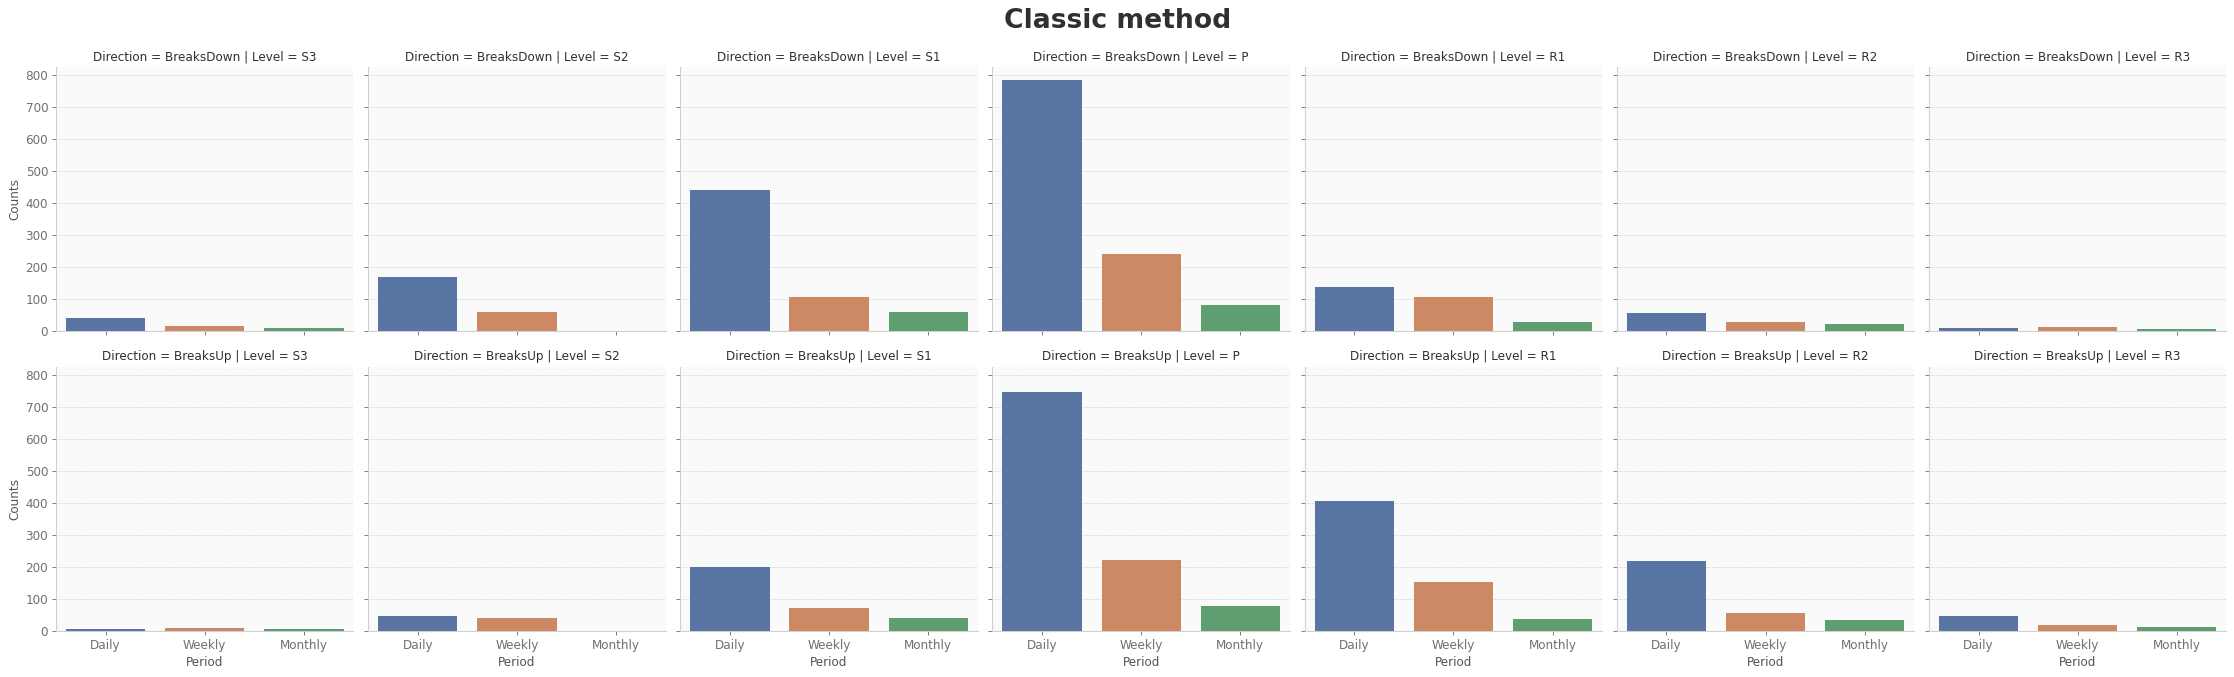

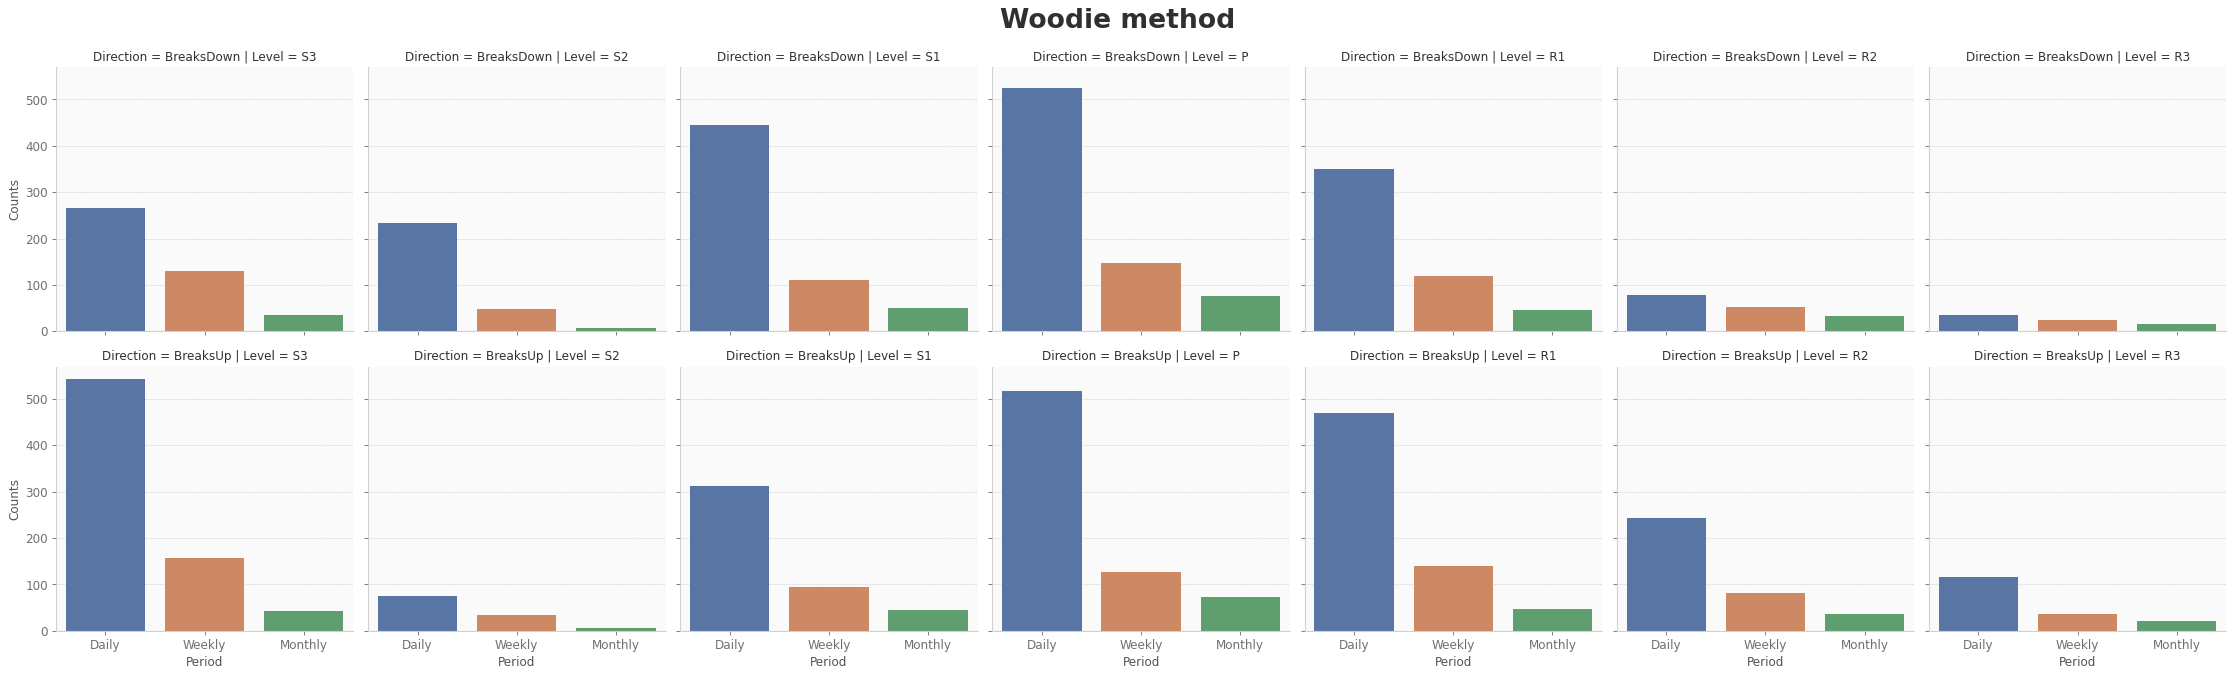

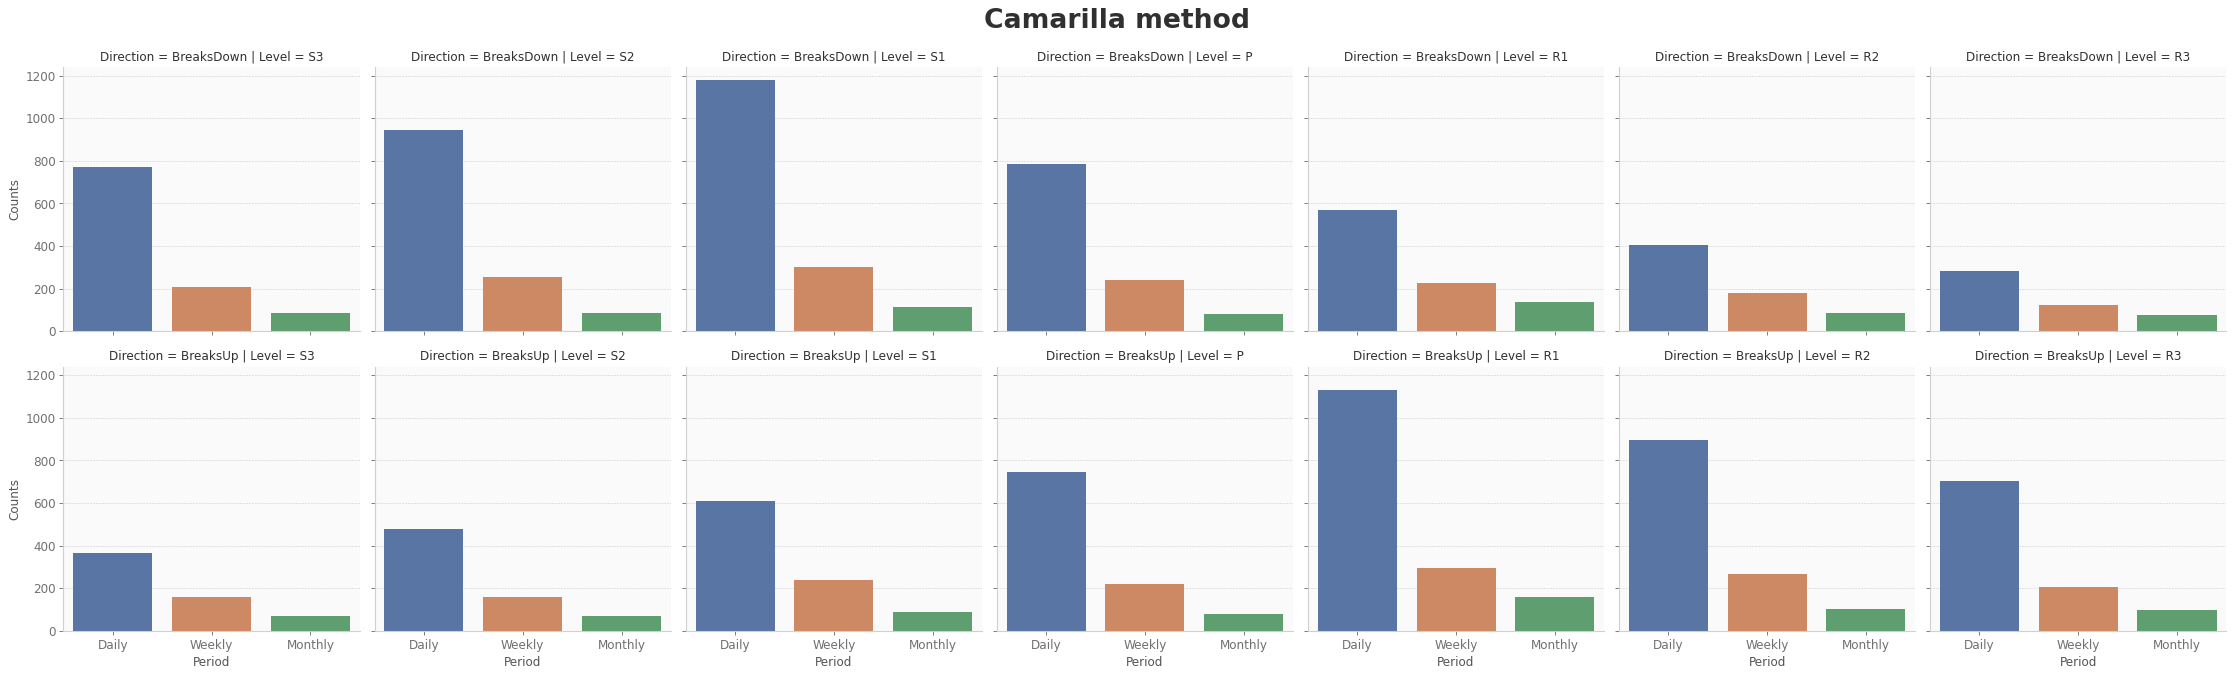

In [565]:
plot_counts(classic, 'Classic method')
plot_counts(woodiw, 'Woodie method')
plot_counts(camarilla, 'Camarilla method')

<b><font color='green' size=4>Conclusions</font></b>
<pre><font color='red' size=2>
 - Most numbers of breakouts occured on P (central pivot levels) on a daily pivots. Levels S1/R1 looks OK
 - We can see for camarilla and woodie methods number of breaks on far supports and resistance is bigger compared to classical pivots (they generate tighter levels) 
</font>
</pre>

# Statisics of forward returns for different parameters

In [566]:
def get_stats(ohlc, poi, nfwd, plot=True, s_fun=lambda x: x.mean()):
    r = make_forward_returns_matrix(ohlc, nfwd, use_open_close=False, use_usd_rets=True)
    s_fun = lambda x: x.mean()
    ht_stats = pd.concat(( s_fun(r.loc[poi[poi > 0].index]), s_fun(r.loc[poi[poi < 0].index])), axis=1, keys=['BreakHi', 'BreakLo'])

    if plot:
        a1 = sbp(21,1); 
        plt.bar(ht_stats.index, ht_stats.BreakHi, color='g'); 
        plt.ylabel(f'BreakUp {levels[0]}')
        plt.xticks(plt.xticks()[0],  [i.split('F')[1] for i in ht_stats.index]);
#         a2 = sbp(21,2);
        a2 = plt.subplot(212, sharex = a1); 
        plt.bar(ht_stats.index, ht_stats.BreakLo, color='r'); plt.ylabel(f'BreakDw {levels[1]}');
        plt.xticks(plt.xticks()[0],  [i.split('F')[1] for i in ht_stats.index]);
        a1.get_shared_x_axes().join(a1, a2)
#         ax1.set_xticklabels([]) 
#         plt.xticks(plt.xticks()[0],  [i.split('F')[1] for i in ht_stats.index]);
        [x.label_outer() for x in [a1 ,a2]]
    
    return mstruct(stats=ht_stats, returns=r)

> classic D: Found 2722 points of interest
> woodie D: Found 2634 points of interest
> camarilla D: Found 5424 points of interest
> classic W: Found 864 points of interest
> woodie W: Found 806 points of interest
> camarilla W: Found 1959 points of interest
> classic M: Found 313 points of interest
> woodie M: Found 343 points of interest
> camarilla M: Found 842 points of interest


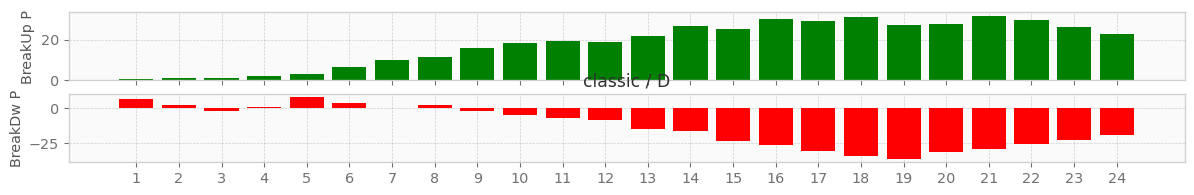

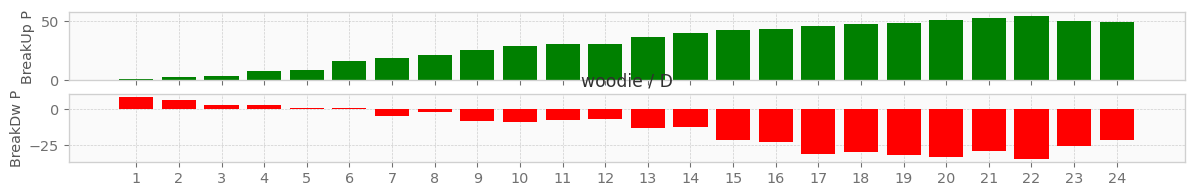

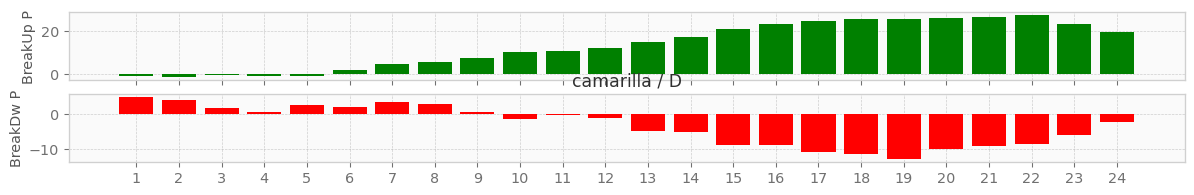

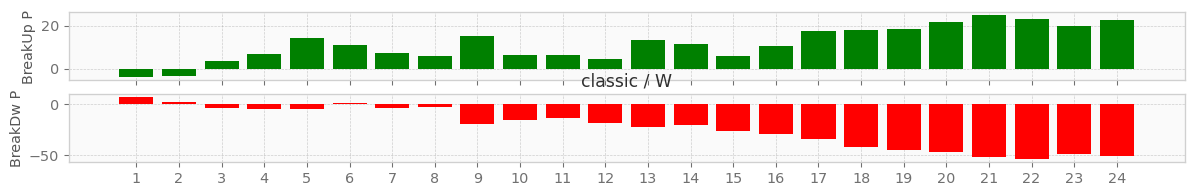

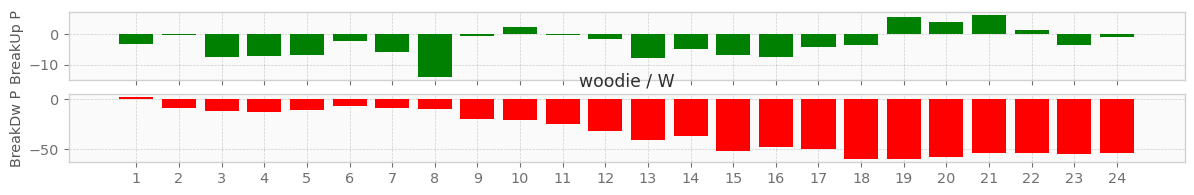

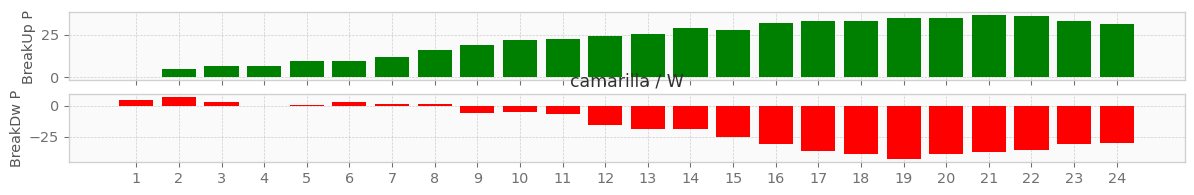

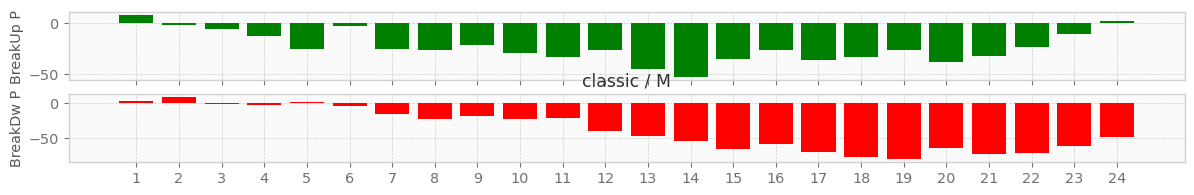

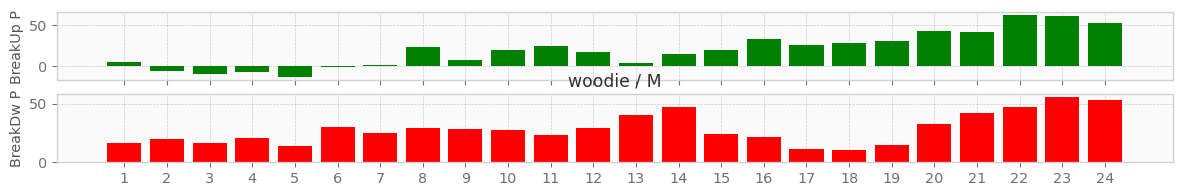

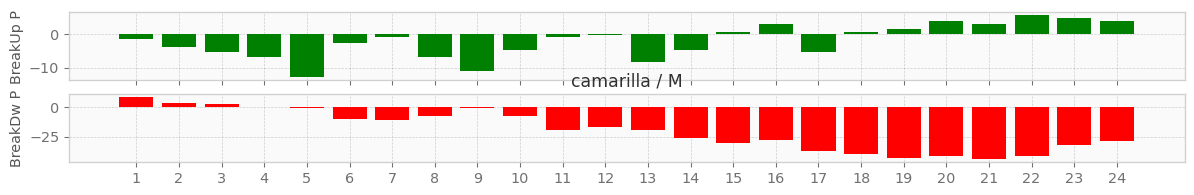

In [567]:
for pp_frame in ['D', 'W', 'M']:
    
    for m in ['classic', 'woodie', 'camarilla']:
        tf = '1H'
        fig(15, 2)
        pdata = find_pp_breakouts(data_1m, tf, 
                                  ['R4', 'R3', 'R2', 'R1', 'P'], # when price breaks up these levels
                                  ['S1', 'S2', 'S3', 'S4', 'P'], # when price breaks down these levels
                                  pp_frame=pp_frame,  method=m)
        print(f'> {m} {pp_frame}: Found {len(pdata.poi)} points of interest')

        xs = get_stats(pdata.ohlc, pdata.poi, 24, True)
        plt.title(f'{m} / {pp_frame}')

Camarilla on Daily would  generate maximal number of signals

# Simple reversing model test

Here we will exploit simplest reversing model to roughly estimate best parameters of breakout model:
  - when price breaks levels 'R4', 'R3', 'R2', 'R1', 'P' up we open long position with size = DEPO / current_instrument_price
  - when price breaks levels 'S1', 'S2', 'S3', 'S4', 'P' down we open short position with size = DEPO / current_instrument_price
  - no risk management (stops/takes)
  - no exits (always in market system)
  - we use $5K as initial deposit

In [524]:
DEPO = 5000
portfolios = {}
for pp_frame in ['D', 'W', 'M']:    
    for m in ['classic', 'woodie', 'camarilla']:
        pdata = find_pp_breakouts(data_1m, tf, 
                                  ['R4', 'R3', 'R2', 'R1', 'P'], # when price breaks up these levels
                                  ['S1', 'S2', 'S3', 'S4', 'P'], # when price breaks down these levels
                                  pp_frame=pp_frame,  method=m)
        
        positions = (pdata.poi * DEPO / pdata.ohlc.close.loc[pdata.poi.index]).rename(instrument)

        pfl = z_test_signals_inplace(shift_signals(positions, seconds=pd.Timedelta(tf).seconds - 1), {instrument: pdata.ohlc}, 'crypto', spread=1, verbose=False)
        portfolios[f'{m}_{pp_frame}'] = pfl

2020-09-28 17:20:51,005 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 10:59:59] will be skipped: no prices found


2020-09-28 17:20:54,143 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 05:59:59] will be skipped: no prices found


2020-09-28 17:20:57,285 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 01:59:59] will be skipped: no prices found


2020-09-28 17:21:00,617 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-22 00:59:59] will be skipped: no prices found


2020-09-28 17:21:03,501 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-21 18:59:59] will be skipped: no prices found


2020-09-28 17:21:06,377 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-21 05:59:59] will be skipped: no prices found


2020-09-28 17:21:10,599 - ira.simulator.SignalTester - WARNING - Positions at [2017-09-04 07:59:59] will be skipped: no prices found


2020-09-28 17:21:13,451 - ira.simulator.SignalTester - WARNING - Positions at [2017-09-02 05:59:59] will be skipped: no prices found


2020-09-28 17:21:16,273 - ira.simulator.SignalTester - WARNING - Positions at [2017-09-02 00:59:59] will be skipped: no prices found


/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/portfolio.py:306: RuntimeWarning:

invalid value encountered in log1p

/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/portfolio.py:306: RuntimeWarning:

invalid value encountered in log1p



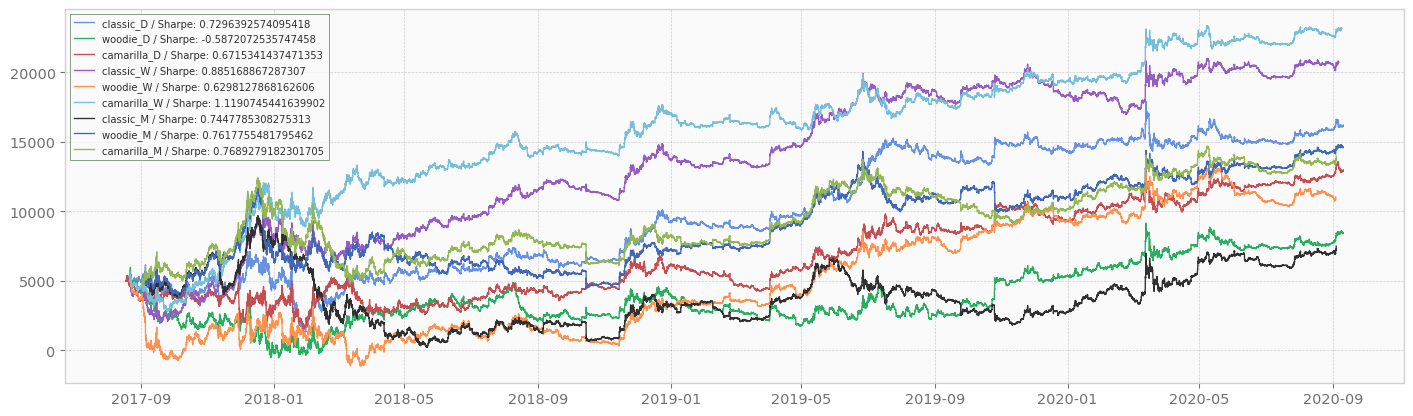

In [568]:
report = {}
fig(18, 5)
for k,p in portfolios.items():
    pstat = portfolio_stats(p, DEPO)
    plt.plot(pstat['equity'], label=f'{k} / Sharpe: {pstat["sharpe"]}')
    report[k] = {'sharpe': pstat["sharpe"], 'cagr': pstat["cagr"], 'maxdd': pstat["mdd_usd"]}
plt.legend()

To see all runs in numbers we collected main properties in common table and sorted it by Sharpe ratio: 

In [569]:
pd.DataFrame.from_dict(report, orient='index').sort_values('sharpe', ascending=False)

,sharpe,cagr,maxdd
camarilla_W,1.119075,0.413668,3211.032237
classic_W,0.885169,0.380562,3614.442295
camarilla_M,0.768928,0.266137,7625.350864
woodie_M,0.761776,0.276732,7200.599948
classic_M,0.744779,0.097581,9466.548312
classic_D,0.729639,0.302761,6039.397769
camarilla_D,0.671534,0.239237,3823.441085
woodie_W,0.629813,0.197195,6499.797965
woodie_D,-0.587207,0.125811,6497.803014


So we can see that Weekly pivots with camarilla calculation method is winner. Also intersting to notice that Daily pivots didn't show good perfomance in breakout model

# Winning model

2020-09-28 17:48:30,163 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-21 05:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,18162.95
CAGR (%):,41.367
Sharpe:,1.119
Sortino:,1.865
Calmar:,0.991
MaxDD (%):,16.142
MaxDD On Init BP (%):,64.221
MaxDD (USD):,3211.032
MaxDD days:,150 days
MaxDD start:,2019-06-26

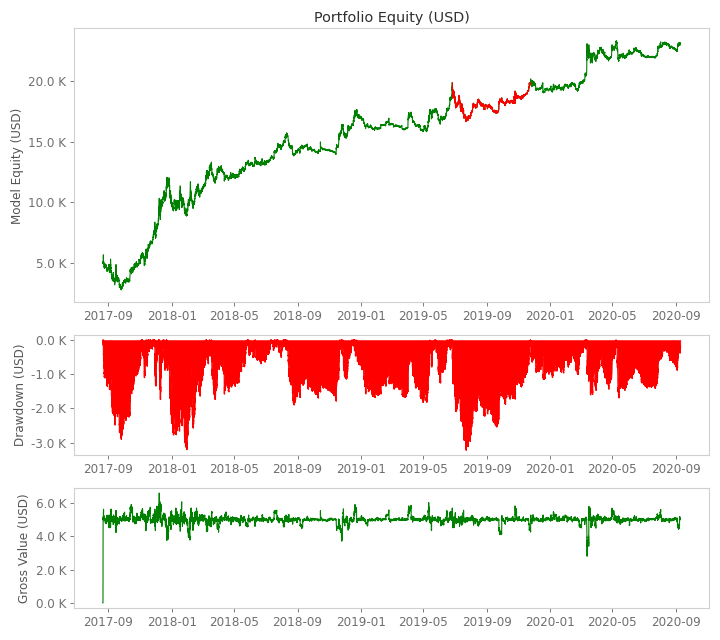

<Figure size 720x640 with 0 Axes>

In [570]:
pdata = find_pp_breakouts(data_1m, '1H', 
                          ['R4', 'R3', 'R2', 'R1', 'P'], # when price breaks up these levels
                          ['S1', 'S2', 'S3', 'S4', 'P'], # when price breaks down these levels
                          pp_frame='W',  method='camarilla')

positions = (pdata.poi * DEPO / pdata.ohlc.close.loc[pdata.poi.index]).rename(instrument)
pfl_winner = z_test_signals_inplace(shift_signals(positions, seconds=pd.Timedelta(tf).seconds - 1), {instrument: pdata.ohlc}, 'crypto', spread=1, verbose=False)
tearsheet(pfl_winner, DEPO, commissions='hitbtc')

Also interesting to see how often we'd see signals on this model:

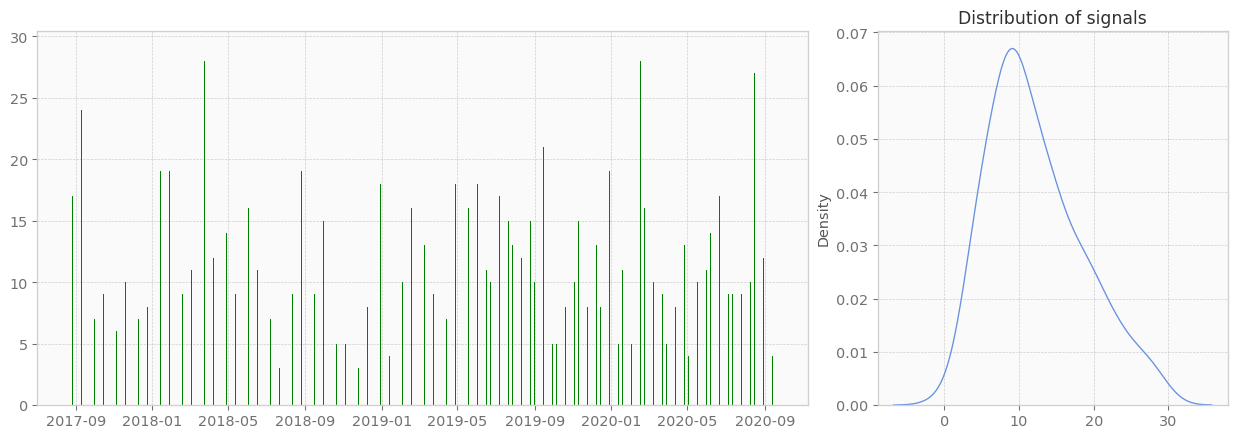

In [571]:
fig(16, 5)
x = pdata.poi.groupby(pd.Grouper(freq='1W')).count()
plt.title('Number of signals per week');
sbp(13,1,c=2);
plt.bar(x.index, x.values, color='g')
sbp(13,3);sns.kdeplot(x);
plt.title('Distribution of signals');

So we can expect 10 signals per week (mode of distribution) with Sharpe > 1.12 and maximal drawdown about 16%. 

CAGR is about 40% (on initially deposited \\$5K we'd get \\$18K terminal profit). 

Transaction costs would be around \\$5K (for HitBtc commissions rules)